# Convolutional Neural Networks: Application

## 1.0 Tensorflow model

In [38]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()


import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from tensorflow.python.framework import ops

%matplotlib inline
np.random.seed(1)

In [39]:
import h5py
import numpy as np

def load_dataset():
    train_dataset = h5py.File('train_signs.h5', "r")
    test_dataset = h5py.File('test_signs.h5', "r")

    X_train_orig = np.array(train_dataset["train_set_x"][:])  # training set features
    Y_train_orig = np.array(train_dataset["train_set_y"][:])  # training set labels

    X_test_orig = np.array(test_dataset["test_set_x"][:])     # test set features
    Y_test_orig = np.array(test_dataset["test_set_y"][:])     # test set labels

    classes = np.array(test_dataset["list_classes"][:])       # list of classes (0–5)

    # reshape labels to (1, number of examples)
    Y_train_orig = Y_train_orig.reshape((1, Y_train_orig.shape[0]))
    Y_test_orig = Y_test_orig.reshape((1, Y_test_orig.shape[0]))

    return X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes


In [40]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()


y =  1


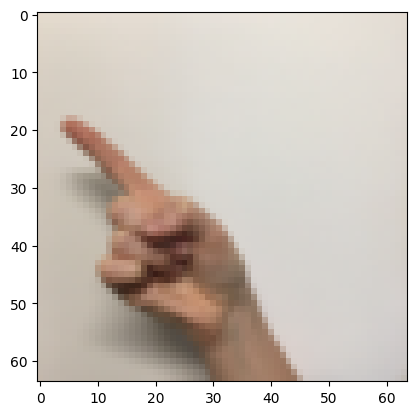

In [41]:
# let's check
idx = 7
plt.imshow(X_train_orig[idx])
print("y = ", str(np.squeeze(Y_train_orig[:, idx])))

In [42]:
def convert_to_one_hot(Y, C):
    """
    Converts a vector of labels Y (shape: 1 × m) into a one-hot encoded matrix (C × m)
    """
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y


In [43]:
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


### 1.1 Create placeholders

In [58]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.compat.v1.placeholder(tf.float32, shape=[None, n_H0, n_W0, n_C0], name='X')
    Y = tf.compat.v1.placeholder(tf.float32, shape=[None, n_y], name='Y')
    return X, Y

In [59]:
X, Y = create_placeholders(64, 64, 3, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("X_7:0", shape=(None, 64, 64, 3), dtype=float32)
Y = Tensor("Y_7:0", shape=(None, 6), dtype=float32)


### 1.2 Initialize parameters:

initialized hard-coded wieights and returned the dictionary of those weights.

In [60]:
def initialize_parameters():
    initializer = tf.keras.initializers.GlorotUniform(seed=0)

    w1 = tf.Variable(initializer(shape=[4, 4, 3, 8]), name="W1")
    w2 = tf.Variable(initializer(shape=[2, 2, 8, 16]), name="W2")
    # Input shape after pooling: 2*2*16 = 64. Output units = 6.
    w3 = tf.Variable(initializer(shape=[64, 6]), name="W3")
    b3 = tf.Variable(tf.zeros([6]), name="b3")

    parameters = {"W1": w1, "W2": w2, "W3": w3, "b3": b3}

    return parameters

In [61]:
# run TF1-style graph code under TF2 using the compatibility API
with tf.compat.v1.Session() as sess_test:
    parameters = initialize_parameters()

    init = tf.compat.v1.global_variables_initializer()
    sess_test.run(init)
    print("W1[1,1,1] = \n" + str(sess_test.run(parameters["W1"])[1,1,1]))
    print("W1.shape: " + str(parameters["W1"].shape))
    print("\n")
    print("W2[1,1,1] = \n" + str(sess_test.run(parameters["W2"])[1,1,1]))
    print("W2.shape: " + str(parameters["W2"].shape))

W1[1,1,1] = 
[-0.05346771  0.18349849 -0.01215445  0.00138046  0.0012947  -0.02904211
 -0.11260509 -0.143055  ]
W1.shape: (4, 4, 3, 8)


W2[1,1,1] = 
[-0.1713624   0.09527719 -0.0744766  -0.02245569  0.24450928 -0.06879854
  0.21546292 -0.08803296 -0.16513646 -0.19527972 -0.22957063  0.15745944
  0.13090086 -0.12304181 -0.05287278  0.03434092]
W2.shape: (2, 2, 8, 16)


### 1.3 Forward propagation:

- In TensorFlow, the softmax and cost function are lumped together into a single function, which you'll call in a different function when computing the cost.

In [62]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    # CONV1
    Z1 = tf.compat.v1.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.compat.v1.nn.max_pool(A1,
                                  ksize=[1, 8, 8, 1],
                                  strides=[1, 8, 8, 1],
                                  padding='SAME')

    # CONV2
    Z2 = tf.compat.v1.nn.conv2d(P1, W2, strides=[1, 1, 1, 1], padding='SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.compat.v1.nn.max_pool(A2,
                                  ksize=[1, 4, 4, 1],
                                  strides=[1, 4, 4, 1],
                                  padding='SAME')

    F = tf.reshape(P2, [-1, 64])
    Z3 = tf.add(tf.matmul(F, W3), b3)

    return Z3


In [63]:
with tf.compat.v1.Session() as sess_test:
    np.random.seed(1)

    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)

    sess_test.run(tf.compat.v1.global_variables_initializer())

    a = sess_test.run(
        Z3,
        {X: np.random.randn(2, 64, 64, 3),
         Y: np.random.randn(2, 6)}
    )

    print("z3 = " + str(a))


z3 = [[-0.14509061  1.917953   -0.20626272 -0.8656838  -0.6806897  -0.739709  ]
 [ 0.02773425  1.7400942  -0.3648245  -1.1037775  -0.5484282  -0.5629161 ]]


### 1.4 Compute Cost:

In [64]:
def compute_cost(z3, Y):
    cost = tf.nn.softmax_cross_entropy_with_logits(logits=z3, labels=Y)
    cost = tf.reduce_mean(cost)
    return cost

In [65]:
with tf.compat.v1.Session() as sess_test:
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    z4 = forward_propagation(X, parameters)
    cost = compute_cost(z4, Y)
    init = tf.compat.v1.global_variables_initializer()
    sess_test.run(init)
    a = sess_test.run(
        cost,
        {X: np.random.randn(4, 64, 64, 3),
         Y: np.random.randn(4, 6)}
    )
    print("cost = " + str(a))

cost = -0.72682214


### 1.5 MODEL:

In [68]:
def random_mini_batches(X, Y, mini_batch_size=64, seed=0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (m, n_H0, n_W0, n_C0)
    Y -- true "label" vector (of shape (m, n_y))
    mini_batch_size -- size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that your "random" minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[0]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :, :, :]
    shuffled_Y = Y[permutation, :]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m / mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : (k + 1) * mini_batch_size, :, :, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : (k + 1) * mini_batch_size, :]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m, :, :, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m, :]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [69]:
def model(X_train, Y_train, X_test, Y_test, lr=0.009, num_epochs=100, minibatch_size=64, print_cost=True):
    ops.reset_default_graph() # to run without overwriting tf variables.
    tf.compat.v1.set_random_seed(1)
    seed = 3
    (m, n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    costs = []

    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    parameters = initialize_parameters()

    Z3 = forward_propagation(X, parameters)

    cost = compute_cost(Z3, Y)

    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=lr).minimize(cost)

    init = tf.compat.v1.global_variables_initializer()

    with tf.compat.v1.Session() as sess:
        sess.run(init)

        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch

                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})

                minibatch_cost += temp_cost / num_minibatches

            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)

        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(lr))
        plt.show()

        predict_op = tf.argmax(Z3, axis=1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, axis=1))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                

        return train_accuracy, test_accuracy, parameters
    

Cost after epoch 0: 1.914684
Cost after epoch 5: 1.400743
Cost after epoch 10: 0.840927
Cost after epoch 15: 0.719414
Cost after epoch 20: 0.594901
Cost after epoch 25: 0.509041
Cost after epoch 30: 0.450073
Cost after epoch 35: 0.433219
Cost after epoch 40: 0.352140
Cost after epoch 45: 0.325396
Cost after epoch 50: 0.288963
Cost after epoch 55: 0.291101
Cost after epoch 60: 0.279201
Cost after epoch 65: 0.289408
Cost after epoch 70: 0.257502
Cost after epoch 75: 0.269621
Cost after epoch 80: 0.308432
Cost after epoch 85: 0.217836
Cost after epoch 90: 0.188386
Cost after epoch 95: 0.211141


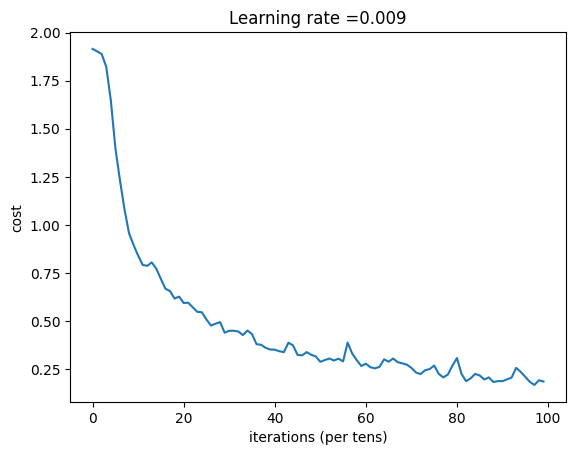

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.9453704
Test Accuracy: 0.7416667


In [70]:
parameters = model(X_train, Y_train, X_test, Y_test)

y =  3


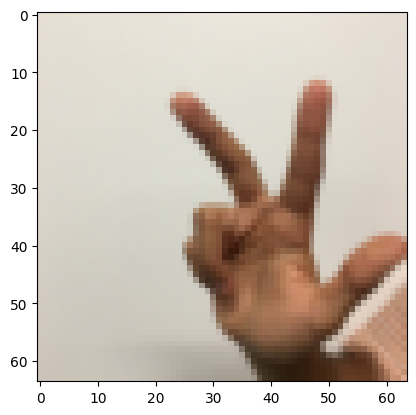

In [71]:
idx = 23
plt.imshow(X_train_orig[idx])
print("y = ", str(np.squeeze(Y_train_orig[:, idx])))

## Finish.
